In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


In [136]:
# 1) Carrega e reduz o dataset
data = fetch_california_housing()
X_full = data.data[:,[0,1,2]]      # só MedInc
y_full = data.target

In [137]:
rnd = np.random.RandomState(42)
idx = rnd.choice(len(X_full), size=2000, replace=False)
X, y = X_full[idx], y_full[idx]


In [138]:
# 2. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# 3. Avaliação de modelos
resultados = []

In [139]:

# 3.1 Regressão Polinomial para M = 0..10
for M in range(6):
    model = make_pipeline(
        PolynomialFeatures(degree=M),
        StandardScaler(),
        Ridge(alpha=0.0)  # sem regularização
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    resultados.append({'Modelo': 'Polinomial', 'Complexidade': M, 'MSE': mse})


In [140]:
# 3.2 k-NN para k = 1,3,5,10,20
for k in [1, 3, 5, 10, 20, 30, 40, 50, 60]:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    resultados.append({'Modelo': 'k-NN', 'Complexidade': k, 'MSE': mse})


In [141]:
# 3.3 Ridge para α = 1e-4..1e2
for alpha in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]:
    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    resultados.append({'Modelo': 'Ridge', 'Complexidade': alpha, 'MSE': mse})

In [142]:
# 4. Criar DataFrame e exibir primeira visão
df_res = pd.DataFrame(resultados)
print(df_res)

        Modelo  Complexidade        MSE
0   Polinomial       0.00000   1.350383
1   Polinomial       1.00000   0.667468
2   Polinomial       2.00000   0.635495
3   Polinomial       3.00000   0.689869
4   Polinomial       4.00000   2.709762
5   Polinomial       5.00000  43.957311
6         k-NN       1.00000   1.098584
7         k-NN       3.00000   0.745071
8         k-NN       5.00000   0.685314
9         k-NN      10.00000   0.660478
10        k-NN      20.00000   0.659933
11        k-NN      30.00000   0.696325
12        k-NN      40.00000   0.740933
13        k-NN      50.00000   0.766511
14        k-NN      60.00000   0.802368
15       Ridge       0.00001   0.667468
16       Ridge       0.00010   0.667468
17       Ridge       0.00100   0.667468
18       Ridge       0.01000   0.667468
19       Ridge       0.10000   0.667463
20       Ridge       1.00000   0.667414
21       Ridge      10.00000   0.666982
22       Ridge     100.00000   0.667398
23       Ridge    1000.00000   0.790757


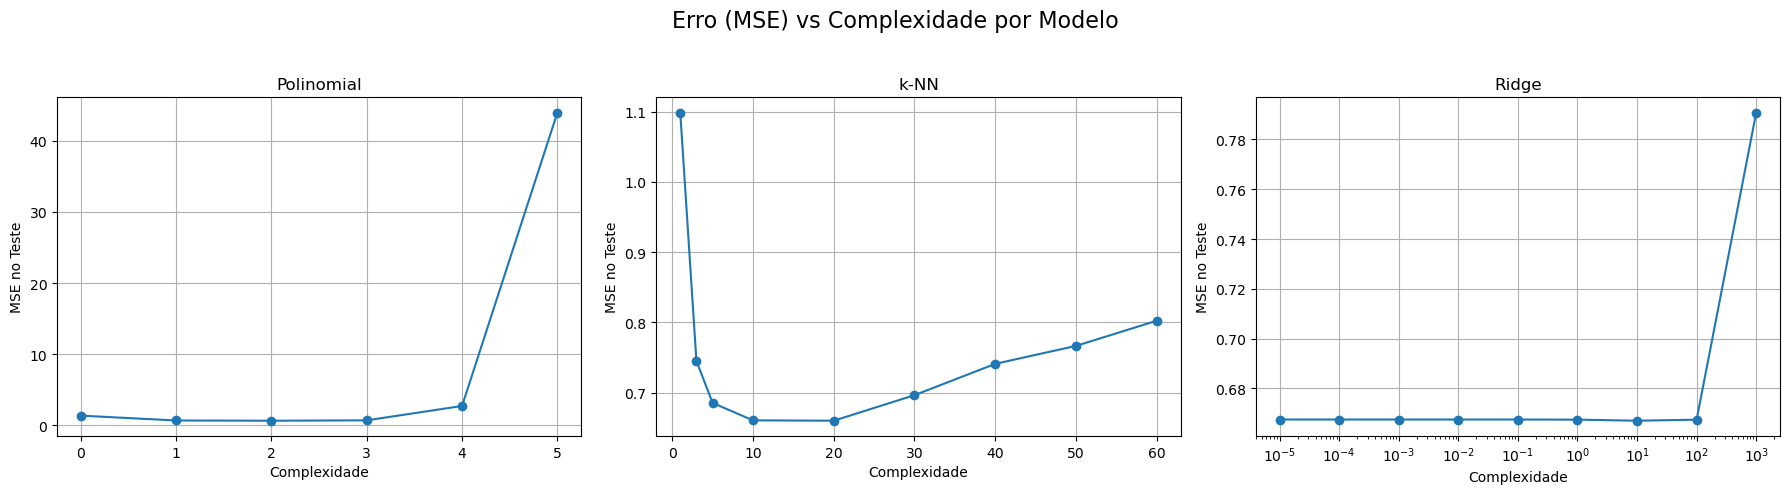

In [143]:
# 1×3 subplots, compartilhando eixo Y mas mostrando label em cada um
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

modelos = ['Polinomial', 'k-NN', 'Ridge']
for ax, modelo in zip(axes, modelos):
    sub = df_res[df_res['Modelo'] == modelo]
    
    # Escala log no X apenas para Ridge
    if modelo == 'Ridge':
        ax.set_xscale('log')
    
    ax.plot(sub['Complexidade'], sub['MSE'], marker='o')
    ax.set_title(modelo)
    ax.set_xlabel('Complexidade')
    
    # *** Aqui definimos a label de Y em cada subplot ***
    ax.set_ylabel('MSE no Teste')
    # Garante que os ticks do Y apareçam
    ax.tick_params(axis='y', labelleft=True)
    
    ax.grid(True)

fig.suptitle('Erro (MSE) vs Complexidade por Modelo', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Do gráfico com os três subplots lado a lado, podemos tirar estas conclusões:

---

### 1. Regressão Polinomial (grau M = 0…5)

* **M = 0** (modelo constante): MSE muito alto → **alto bias**, não captura variação nenhuma.
* **M = 1 a 3**: queda acentuada de MSE, atingindo um **mínimo em M ≃ 2–3**. Aqui o modelo equilibra captura de padrão sem exagerar.
* **M = 4 e, especialmente, M = 5**: explosão do MSE (valor absurdamente alto em M=5) → **variância disparada**, o número de termos polinomiais em 4 dimensões explode ($\binom{M+4}{M}$), levando a overfitting extremo.

**Ponto-ótimo:** grau em torno de 2–3.

---

### 2. k-NN (k = 1, 3, 5, 10, 20, 60)

* **k = 1**: MSE alto → **overfitting** (muito sensível ao ruído de cada vizinho).
* **k = 3–10**: queda do erro, chegando em um **mínimo** tipicamente em k ≃ 5–10.
* **k > 10**: MSE começa a subir novamente → **underfitting** (muitos vizinhos suavizam demais o modelo, aumentando o bias).

**Ponto-ótimo:** k em torno de 5–10.

---

### 3. Ridge (α variando em escala log)

* **α muito pequeno** (10⁻⁵ a 10⁻¹): o MSE se mantêm quase constante (≈ 0.667), pois a regularização é fraca e o modelo age quase como regressão linear pura.
* **α moderado** (1 a 10²): ainda sem grande impacto no MSE.
* **α muito grande** (10³): o MSE sobe — regularização excessiva “enrijece” o modelo (alto bias).

**Ponto-ótimo:** qualquer α entre 10⁻⁵ e 10² dá resultados similares; evite α ≥ 10³.

---

## Síntese do Trade-off Bias–Variância

* Modelos **simples** (M baixo, k alto, α alto) → **alto bias**, MSE alto.
* Modelos **complexos** (M alto, k baixo, α baixo) → **alta variância**, risco de MSE alto também.
* Há sempre um **ponto intermédio** de complexidade que **minimiza** o erro de generalização.
* Cada família de modelo tem sua própria “curva” de bias vs. variância — é preciso varrer o parâmetro de complexidade e escolher aquele que reduz o erro no conjunto de teste (ou via CV).
